# This file serves to demonstrate how to use a function defined in this package.
Specifically, it serves to show how to use the calc_calc_hysteresis_area_3D function to compute hysteresis area. It also computes the loop gaps using the function calc_loop_gap_3D.

Note that the ref_axis needs to be strictly monotonically changing to the global extremum and strictly monotonically changing afterwards. Otherwise, unwanted behaviour can occur.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Importing the functions from the package
import sys
sys.path.insert(0,'/home/ekoehn/software/')
import hysteresis # import the package
from hysteresis import hyst_areas as ha # import the submodule hyst_areas
from hysteresis import loop_metrics as lm # import the submodule loop_metrics

# reload the modules in case there were some changes
import importlib
importlib.reload(ha)
importlib.reload(lm)

<module 'hysteresis.loop_metrics' from '/home/ekoehn/software/hysteresis/loop_metrics.py'>

## Set up the demo

In [2]:
# Define dimensions
n_years = 180
n_lat = 50
n_lon = 100

# Generate coordinate arrays
years = np.arange(n_years)
lats = np.linspace(-90, 90, n_lat)
lons = np.linspace(-180, 180, n_lon)

# Create a meshgrid of lat/lon to generate unique sinusoidal patterns at each location
lat_grid, lon_grid = np.meshgrid(lats, lons, indexing='ij')

# Generate a unique sinusoidal signal at each (lat, lon) location
# The phase and amplitude vary slightly per location for uniqueness
amplitudes = 1 + 0.5 * np.sin(np.radians(lat_grid))  # Amplitude varies with latitude
phases = np.radians(lon_grid)  # Phase shift varies with longitude

# Create the time-dependent data
data = np.array([
    amplitudes * np.sin(2 * np.pi * years[i] / n_years + phases)
    for i in range(n_years)
])

# Convert to an xarray DataArray
da = xr.DataArray(
    data,
    coords={"year": years, "lat": lats, "lon": lons},
    dims=["year", "lat", "lon"]
)

# Dfine the reference axis
ref_axis = np.sin(np.linspace(-np.pi/2,3/2*np.pi,n_years)) # strictly monotonically increasing and then strictly monotonically decreasing reference axis over a 2pi cycle


## Plot example locations

Text(0.5, 0.98, 'Example time series at different locations')

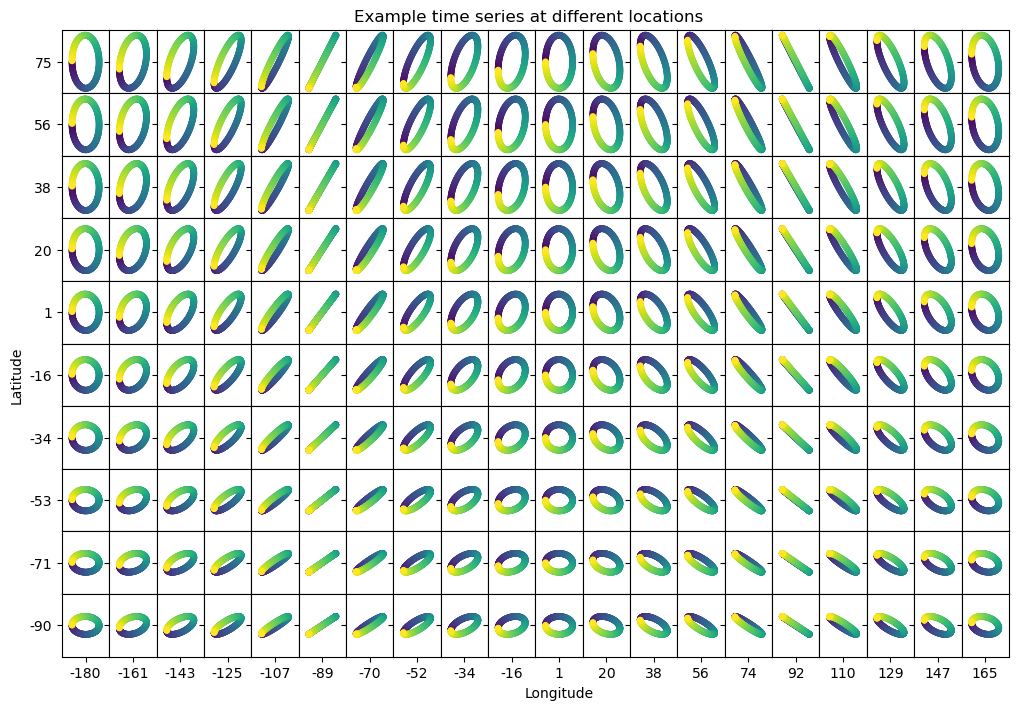

In [3]:
res = 5
fig,ax = plt.subplots(int(n_lat/res),int(n_lon/res),sharex='col',sharey='row',figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)

lats_subsampled = lats[::res]
lons_subsampled = lons[::res]

for lati,lat in enumerate(lats_subsampled):
    lati2 = np.size(lats_subsampled)-lati-1
    for loni,lon in enumerate(lons_subsampled):
        # "flip" the lati to have the right order from "north" to "south" in the way the subplots appear
        ax[lati2,loni].scatter(ref_axis,da.sel(lat=lat,lon=lon),15,np.arange(n_years))
        ax[lati2,loni].set_yticks([0])
        ax[lati2,loni].set_yticklabels([int(lat)])
        ax[lati2,loni].set_xticks([0])
        ax[lati2,loni].set_xticklabels([int(lon)])
        ax[lati2,loni].set_xlim([-1.75,1.75])
        ax[lati2,loni].set_ylim([-1.75,1.75])
ax[-1,int(len(lons_subsampled)/2)].set_xlabel('Longitude')
ax[int(len(lats_subsampled)/2),0].set_ylabel('Latitude')
plt.subplots_adjust(top=0.95)
fig.suptitle('Example time series at different locations')

## Do the calculation of the hysteresis area and return the hysteresis metrics

In [4]:
normalizer = 'min_max_diff_full_cycle'
ds = ha.calc_hysteresis_area_3D(ref_axis, da, nsteps=1000, normalizer=normalizer,return_interpolated_vectors=True)

/home/ekoehn/software/hysteresis/hyst_areas.py:45: RuntimeWarning: Reference axis does not have a single clear peak. Results may be unreliable.
  warnings.warn("Reference axis does not have a single clear peak. Results may be unreliable.", RuntimeWarning)


## Check interpolated rampup and rampdown parts of one interpolated time series

Text(0, 0.5, 'Interpolated rampup (blue), rampdown (orange)')

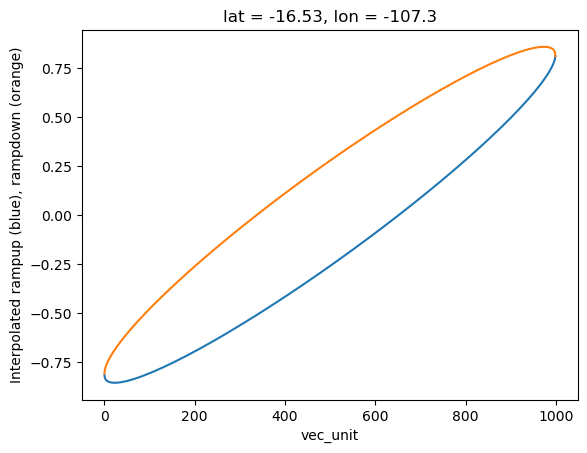

In [5]:
ds.interpolated_rampup.isel(lat=20,lon=20).plot()
ds.interpolated_rampdown.isel(lat=20,lon=20).plot()
plt.ylabel('Interpolated rampup (blue), rampdown (orange)')

## Plot the calculated hysteresis areas for all locations

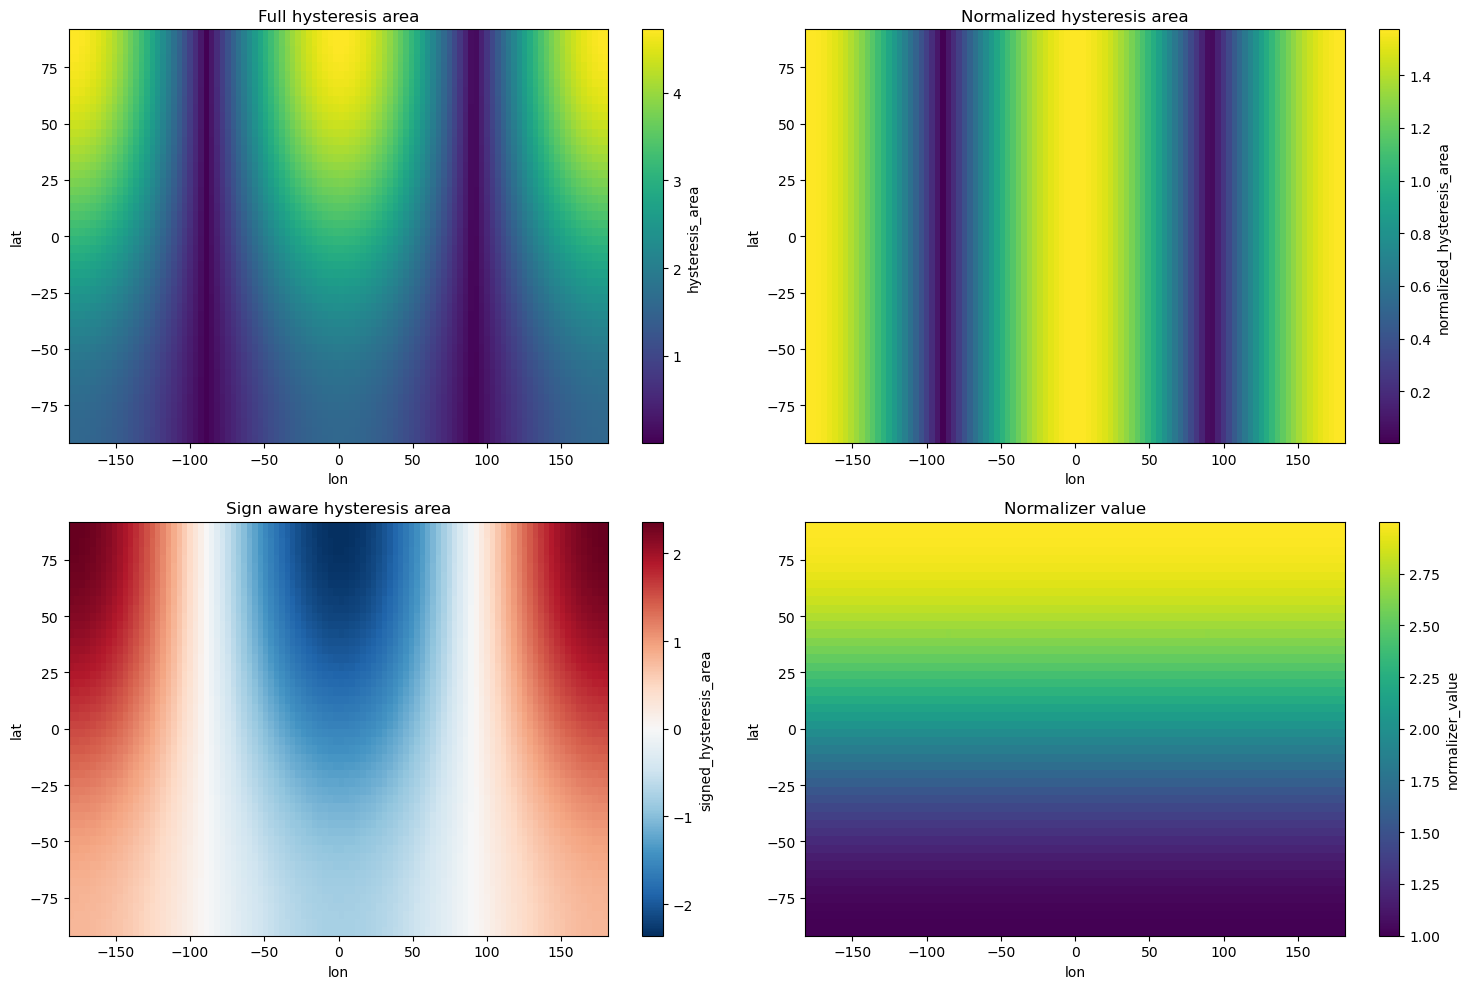

In [6]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
ds.hysteresis_area.plot(ax=ax[0,0])
ax[0,0].set_title('Full hysteresis area')
ds.signed_hysteresis_area.plot(ax=ax[1,0])
ax[1,0].set_title("Sign aware hysteresis area")
ds.normalized_hysteresis_area.plot(ax=ax[0,1])
ax[0,1].set_title("Normalized hysteresis area")
ds.normalizer_value.plot(ax=ax[1,1])
ax[1,1].set_title("Normalizer value")
plt.tight_layout()
plt.show()

## Note, that if the initial values in the rampup/rampdown are not the same, the interpolated rampup/rampdown vectors will carry NaNs for these parts of the vectors. Hence the final hysteresis area is only calculated over the parts where both the rampup and rampdown vectors are defined.

### See the following example

In [7]:
# Define dimensions
n_years = 180
n_lat = 50
n_lon = 100

# Generate coordinate arrays
years = np.arange(n_years)
lats = np.linspace(-90, 90, n_lat)
lons = np.linspace(-180, 180, n_lon)

# Create a meshgrid of lat/lon to generate unique sinusoidal patterns at each location
lat_grid, lon_grid = np.meshgrid(lats, lons, indexing='ij')

# Generate a unique sinusoidal signal at each (lat, lon) location
# The phase and amplitude vary slightly per location for uniqueness
amplitudes = 1 + 0.5 * np.sin(np.radians(lat_grid))  # Amplitude varies with latitude
phases = np.radians(lon_grid)  # Phase shift varies with longitude

# Create the time-dependent data
data = np.array([
    amplitudes * np.sin(2 * np.pi * years[i] / n_years + phases)
    for i in range(n_years)
])

# Convert to an xarray DataArray
da = xr.DataArray(
    data,
    coords={"year": years, "lat": lats, "lon": lons},
    dims=["year", "lat", "lon"]
)

# Dfine the reference axis
ref_axis = np.sin(np.linspace(-np.pi/2,np.pi,n_years)) # strictly monotonically increasing and then strictly monotonically decreasing reference axis over a 2pi cycle


Text(0.5, 0.98, 'Example time series at different locations')

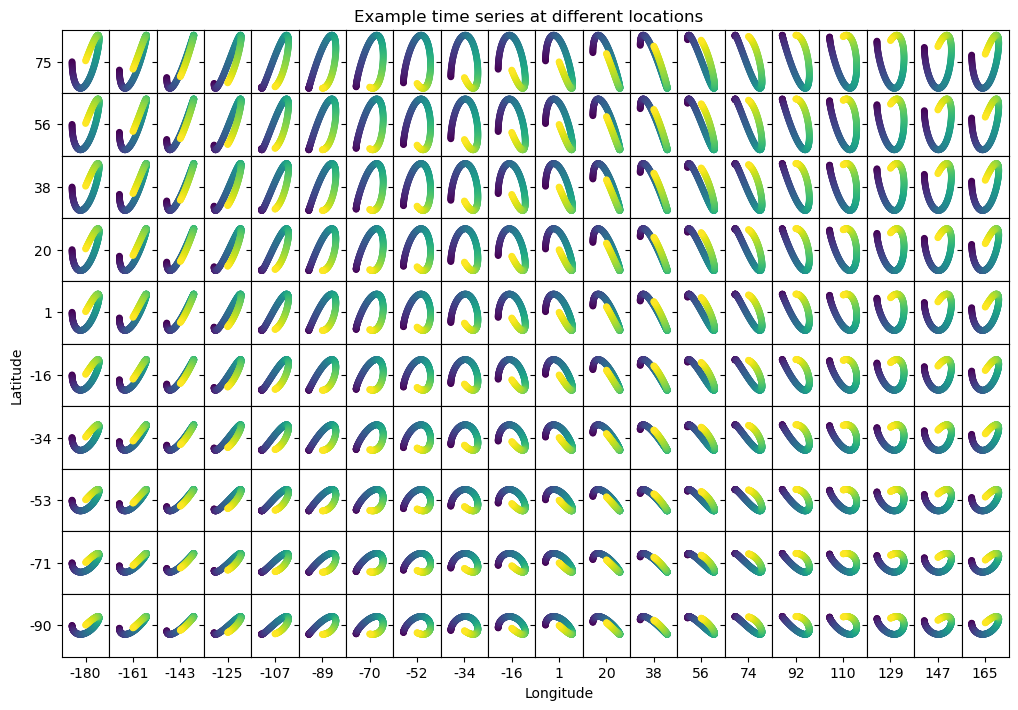

In [8]:
res = 5
fig,ax = plt.subplots(int(n_lat/res),int(n_lon/res),sharex='col',sharey='row',figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)

lats_subsampled = lats[::res]
lons_subsampled = lons[::res]

for lati,lat in enumerate(lats_subsampled):
    lati2 = np.size(lats_subsampled)-lati-1
    for loni,lon in enumerate(lons_subsampled):
        # "flip" the lati to have the right order from "north" to "south" in the way the subplots appear
        ax[lati2,loni].scatter(ref_axis,da.sel(lat=lat,lon=lon),15,np.arange(n_years))
        ax[lati2,loni].set_yticks([0])
        ax[lati2,loni].set_yticklabels([int(lat)])
        ax[lati2,loni].set_xticks([0])
        ax[lati2,loni].set_xticklabels([int(lon)])
        ax[lati2,loni].set_xlim([-1.75,1.75])
        ax[lati2,loni].set_ylim([-1.75,1.75])
ax[-1,int(len(lons_subsampled)/2)].set_xlabel('Longitude')
ax[int(len(lats_subsampled)/2),0].set_ylabel('Latitude')
plt.subplots_adjust(top=0.95)
fig.suptitle('Example time series at different locations')

In [9]:
normalizer = 'min_max_diff_full_cycle'
ds = ha.calc_hysteresis_area_3D(ref_axis, da, nsteps=1000, normalizer=normalizer,return_interpolated_vectors=True)

## Check interpolated rampup and rampdown parts of one interpolated time series

Text(0, 0.5, 'Interpolated rampup (blue), rampdown (orange)')

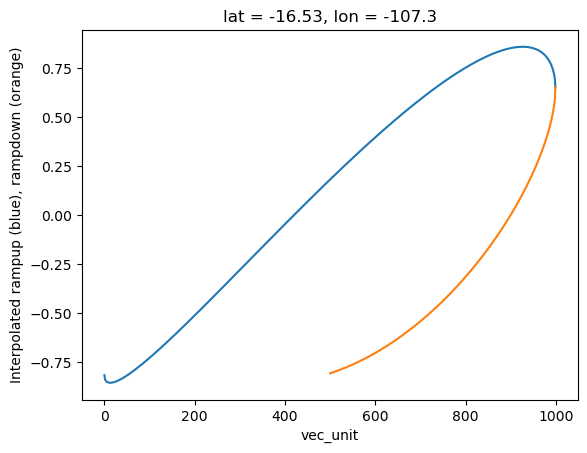

In [10]:
ds.interpolated_rampup.isel(lat=20,lon=20).plot()
ds.interpolated_rampdown.isel(lat=20,lon=20).plot()
plt.ylabel('Interpolated rampup (blue), rampdown (orange)')

## Plot the calculated hysteresis areas for all locations

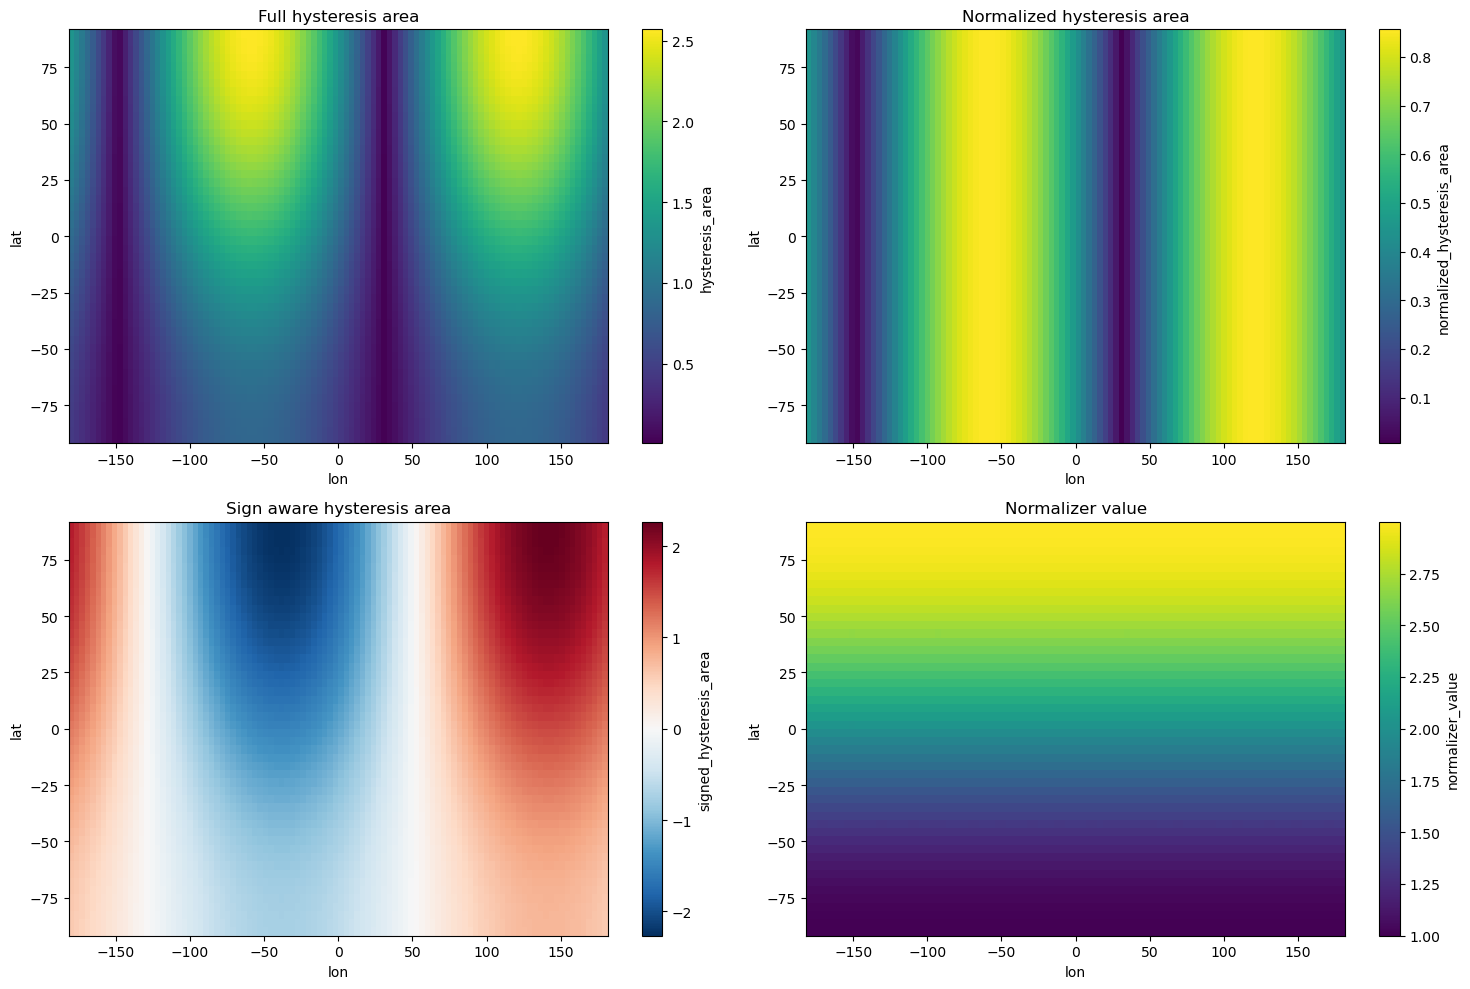

In [11]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
ds.hysteresis_area.plot(ax=ax[0,0])
ax[0,0].set_title('Full hysteresis area')
ds.signed_hysteresis_area.plot(ax=ax[1,0])
ax[1,0].set_title("Sign aware hysteresis area")
ds.normalized_hysteresis_area.plot(ax=ax[0,1])
ax[0,1].set_title("Normalized hysteresis area")
ds.normalizer_value.plot(ax=ax[1,1])
ax[1,1].set_title("Normalizer value")
plt.tight_layout()
plt.show()

## Now, for this open case, calculate the loop gap, which is in this case evaluated at the location 0 on the reference axis

In [12]:
normalizer = 'min_max_diff_full_cycle'
ds_loopgap = lm.calc_loop_gap_3D(ref_axis, da, nsteps=1000, n_ave=10, normalizer=normalizer)

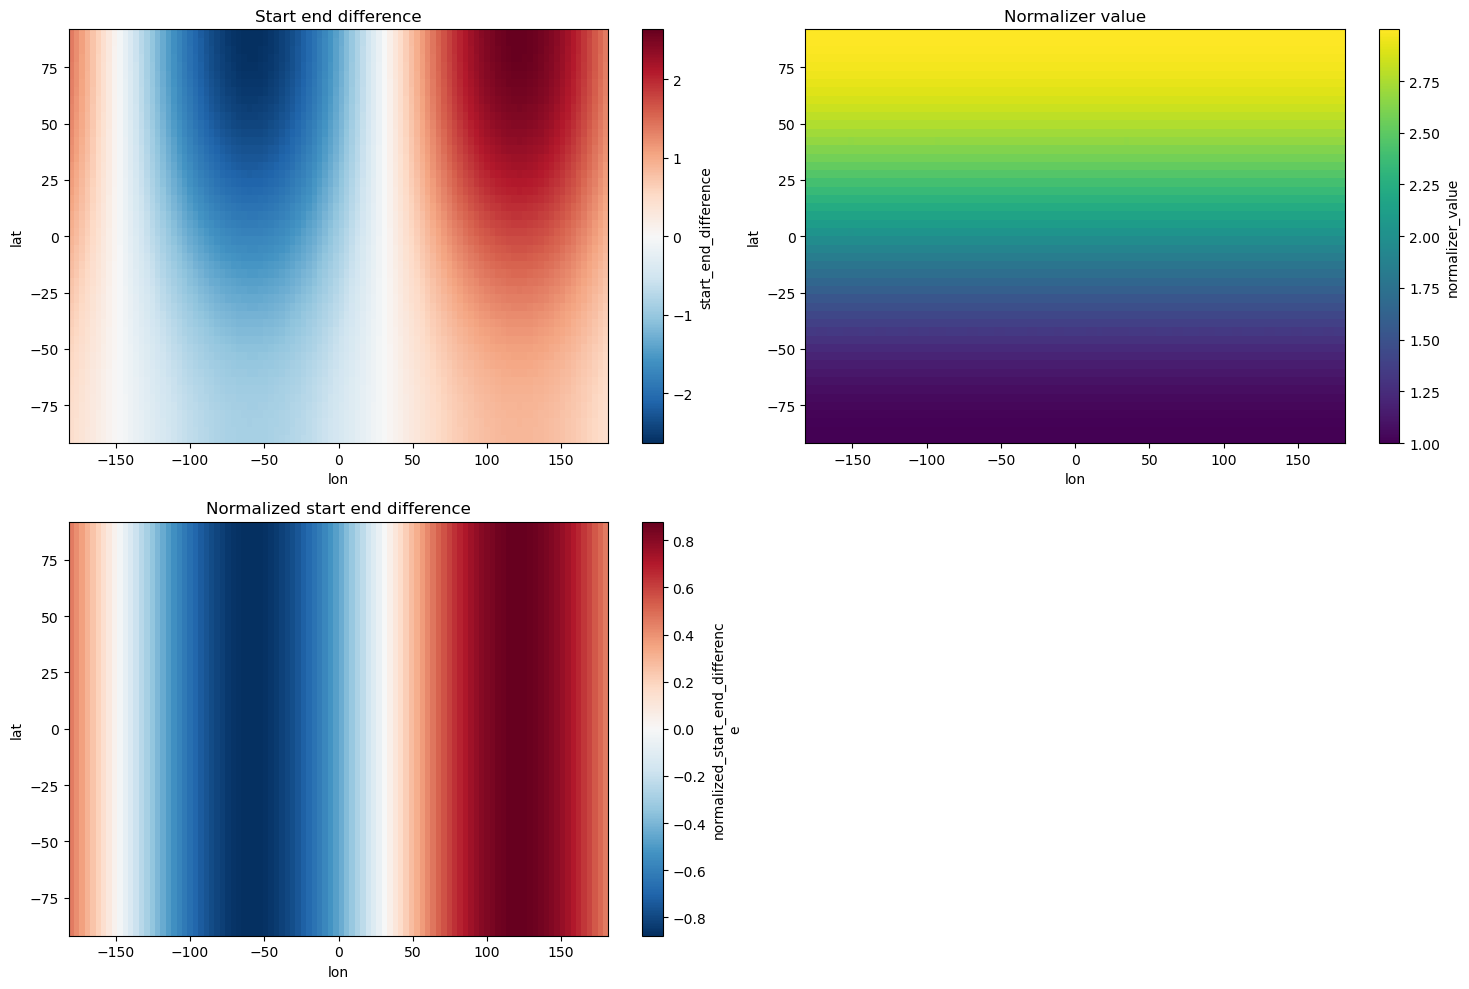

In [13]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
ds_loopgap.start_end_difference.plot(ax=ax[0,0])
ax[0,0].set_title('Start end difference')
ds_loopgap.normalized_start_end_difference.plot(ax=ax[1,0])
ax[1,0].set_title('Normalized start end difference')
ds_loopgap.normalizer_value.plot(ax=ax[0,1])
ax[0,1].set_title('Normalizer value')
ax[1,1].set_visible(False)
plt.tight_layout()
plt.show()